In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# =============================================================================
#  1. DATA LOADING AND PREPROCESSING FUNCTIONS
# =============================================================================

def load_session_data(base_data_path, subject_id, session_id):
    # Loads EEG data and labels for a specific subject and session.
    try:
        data_path = os.path.join(base_data_path, f'SBJ{subject_id:02d}', f'S{session_id:02d}', 'Train')
        mat_file = os.path.join(data_path, 'trainData.mat')
        targets_file = os.path.join(data_path, 'trainTargets.txt')
        
        mat_contents = sio.loadmat(mat_file)
        eeg_data = mat_contents['trainData']
        labels = np.loadtxt(targets_file, dtype=int)
        return eeg_data, labels
    except FileNotFoundError:
        return None, None

def preprocess_eeg(eeg_data, sampling_rate=250):
    # Applies band-pass, notch filtering, and baseline correction.
    # Band-pass Filter
    low_cut, high_cut = 0.5, 30
    b_band, a_band = butter(4, [low_cut, high_cut], btype='band', fs=sampling_rate)
    eeg_filtered = filtfilt(b_band, a_band, eeg_data, axis=1)

    # Notch Filter
    notch_freq, q_factor = 50.0, 30.0
    b_notch, a_notch = iirnotch(notch_freq, q_factor, sampling_rate)
    eeg_filtered = filtfilt(b_notch, a_notch, eeg_filtered, axis=1)

    # Baseline Correction
    baseline_samples = int(0.2 * sampling_rate)
    baseline_mean = np.mean(eeg_filtered[:, :baseline_samples, :], axis=1, keepdims=True)
    eeg_preprocessed = eeg_filtered - baseline_mean
    return eeg_preprocessed

def extract_features(eeg_data, sampling_rate=250):
    # Extracts features from a specific time window and flattens the data.
    start_sample = int((200 + 100) * (sampling_rate / 1000))
    end_sample = int((200 + 700) * (sampling_rate / 1000))
    
    eeg_windowed = eeg_data[:, start_sample:end_sample, :]
    
    num_events = eeg_windowed.shape[2]
    num_features = eeg_windowed.shape[0] * eeg_windowed.shape[1]
    
    features = eeg_windowed.transpose(2, 0, 1).reshape(num_events, num_features)
    return features

# =============================================================================
#  2. MAIN ANALYSIS LOOP
# =============================================================================

base_data_path = '../data/'
subjects_to_process = range(1, 16)  # Subjects 1 to 15
sessions_to_process = range(1, 8)   # Sessions 1 to 7

results = []

for subject_id in subjects_to_process:
    for session_id in sessions_to_process:
        print(f"--- Processing Subject {subject_id:02d}, Session {session_id:02d} ---")
        
        # Load
        eeg_data, labels = load_session_data(base_data_path, subject_id, session_id)
        if eeg_data is None:
            print("Session data not found. Skipping.")
            continue
        
        # Preprocess
        eeg_preprocessed = preprocess_eeg(eeg_data)
        
        # Feature Extraction
        features = extract_features(eeg_preprocessed)
        
        # Model Training and Evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.25, random_state=42, stratify=labels
        )
        
        model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
        model.fit(X_train, y_train)
        
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        
        results.append({
            'Subject': f'SBJ{subject_id:02d}',
            'Session': f'S{session_id:02d}',
            'AUC': auc
        })
        
        print(f"‚úÖ Done. ROC-AUC Score: {auc:.3f}\n")

# --- 3. AGGREGATE AND VISUALIZE RESULTS ---
results_df = pd.DataFrame(results)

print("\n--- Overall Performance Summary ---")
print(results_df.describe())

# Plotting the results
plt.figure(figsize=(15, 7))
results_df.boxplot(column='AUC', by='Subject')
plt.title('Model Performance (AUC) by Subject')
plt.suptitle('') # Suppress the default title
plt.xlabel('Subject ID')
plt.ylabel('ROC-AUC Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

--- Processing ALL SESSIONS for Subject 01 ---
Total data for Subject 01: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.758

--- Processing ALL SESSIONS for Subject 02 ---
Total data for Subject 02: 11200 events


c:\Work_Directory\neurosense_project\venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


‚úÖ Done. Subject-Specific Model AUC: 0.874

--- Processing ALL SESSIONS for Subject 03 ---
Total data for Subject 03: 11200 events


c:\Work_Directory\neurosense_project\venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


‚úÖ Done. Subject-Specific Model AUC: 0.766

--- Processing ALL SESSIONS for Subject 04 ---
Total data for Subject 04: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.833

--- Processing ALL SESSIONS for Subject 05 ---
Total data for Subject 05: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.801

--- Processing ALL SESSIONS for Subject 06 ---
Total data for Subject 06: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.795

--- Processing ALL SESSIONS for Subject 07 ---
Total data for Subject 07: 11200 events


c:\Work_Directory\neurosense_project\venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


‚úÖ Done. Subject-Specific Model AUC: 0.816

--- Processing ALL SESSIONS for Subject 08 ---
Total data for Subject 08: 11200 events


c:\Work_Directory\neurosense_project\venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


‚úÖ Done. Subject-Specific Model AUC: 0.853

--- Processing ALL SESSIONS for Subject 09 ---
Total data for Subject 09: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.764

--- Processing ALL SESSIONS for Subject 10 ---
Total data for Subject 10: 11200 events


c:\Work_Directory\neurosense_project\venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


‚úÖ Done. Subject-Specific Model AUC: 0.898

--- Processing ALL SESSIONS for Subject 11 ---
Total data for Subject 11: 11200 events


c:\Work_Directory\neurosense_project\venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


‚úÖ Done. Subject-Specific Model AUC: 0.839

--- Processing ALL SESSIONS for Subject 12 ---
Total data for Subject 12: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.808

--- Processing ALL SESSIONS for Subject 13 ---
Total data for Subject 13: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.772

--- Processing ALL SESSIONS for Subject 14 ---
Total data for Subject 14: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.734

--- Processing ALL SESSIONS for Subject 15 ---
Total data for Subject 15: 11200 events
‚úÖ Done. Subject-Specific Model AUC: 0.767


--- Subject-Specific Model Performance Summary ---
              AUC
Subject          
SBJ01    0.758055
SBJ02    0.873571
SBJ03    0.765518
SBJ04    0.833103
SBJ05    0.800837
SBJ06    0.794602
SBJ07    0.816357
SBJ08    0.853145
SBJ09    0.764017
SBJ10    0.897752
SBJ11    0.839108
SBJ12    0.807553
SBJ13    0.771683
SBJ14    0.734320
SBJ15    0.767451


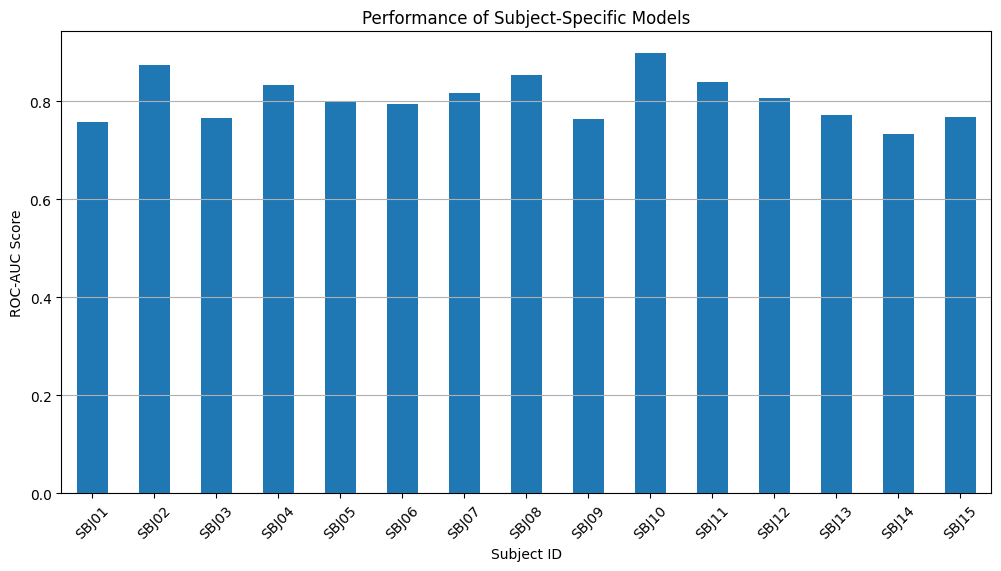

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# --- (Keep your data loading and preprocessing functions from before) ---
def load_session_data(base_data_path, subject_id, session_id):
    # Loads EEG data and labels for a specific subject and session.
    try:
        data_path = os.path.join(base_data_path, f'SBJ{subject_id:02d}', f'S{session_id:02d}', 'Train')
        mat_file = os.path.join(data_path, 'trainData.mat')
        targets_file = os.path.join(data_path, 'trainTargets.txt')

        mat_contents = sio.loadmat(mat_file)
        eeg_data = mat_contents['trainData']
        labels = np.loadtxt(targets_file, dtype=int)
        return eeg_data, labels
    except FileNotFoundError:
        return None, None

def preprocess_eeg(eeg_data, sampling_rate=250):
    # Applies band-pass, notch filtering, and baseline correction.
    low_cut, high_cut = 0.5, 30
    b_band, a_band = butter(4, [low_cut, high_cut], btype='band', fs=sampling_rate)
    eeg_filtered = filtfilt(b_band, a_band, eeg_data, axis=1)

    notch_freq, q_factor = 50.0, 30.0
    b_notch, a_notch = iirnotch(notch_freq, q_factor, sampling_rate)
    eeg_filtered = filtfilt(b_notch, a_notch, eeg_filtered, axis=1)

    baseline_samples = int(0.2 * sampling_rate)
    baseline_mean = np.mean(eeg_filtered[:, :baseline_samples, :], axis=1, keepdims=True)
    eeg_preprocessed = eeg_filtered - baseline_mean
    return eeg_preprocessed

def extract_features(eeg_data, sampling_rate=250):
    # Extracts features from a specific time window and flattens the data.
    start_sample = int((200 + 100) * (sampling_rate / 1000))
    end_sample = int((200 + 700) * (sampling_rate / 1000))

    eeg_windowed = eeg_data[:, start_sample:end_sample, :]

    num_events = eeg_windowed.shape[2]
    num_features = eeg_windowed.shape[0] * eeg_windowed.shape[1]

    features = eeg_windowed.transpose(2, 0, 1).reshape(num_events, num_features)
    return features


# =============================================================================
#  2. MODIFIED ANALYSIS: TRAIN ONE MODEL PER SUBJECT
# =============================================================================

base_data_path = '../data/'
subjects_to_process = range(1, 16)
sessions_to_process = range(1, 8)

subject_results = []

for subject_id in subjects_to_process:
    print(f"--- Processing ALL SESSIONS for Subject {subject_id:02d} ---")
    
    # Placeholders to accumulate data for the subject
    subject_features_list = []
    subject_labels_list = []
    
    for session_id in sessions_to_process:
        eeg_data, labels = load_session_data(base_data_path, subject_id, session_id)
        if eeg_data is None:
            continue
        
        eeg_preprocessed = preprocess_eeg(eeg_data)
        features = extract_features(eeg_preprocessed)
        
        subject_features_list.append(features)
        subject_labels_list.append(labels)
        
    # Check if we gathered any data for this subject
    if not subject_features_list:
        print("No data found for this subject. Skipping.")
        continue

    # Combine all session data for the subject
    X_subject = np.vstack(subject_features_list)
    y_subject = np.concatenate(subject_labels_list)
    
    print(f"Total data for Subject {subject_id:02d}: {X_subject.shape[0]} events")

    # Train a single model on this subject's combined data
    X_train, X_test, y_train, y_test = train_test_split(
        X_subject, y_subject, test_size=0.25, random_state=42, stratify=y_subject
    )
    
    model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    
    subject_results.append({
        'Subject': f'SBJ{subject_id:02d}',
        'AUC': auc
    })
    
    print(f"‚úÖ Done. Subject-Specific Model AUC: {auc:.3f}\n")

# --- 3. AGGREGATE AND VISUALIZE SUBJECT-SPECIFIC RESULTS ---
subject_results_df = pd.DataFrame(subject_results)

print("\n--- Subject-Specific Model Performance Summary ---")
print(subject_results_df.set_index('Subject'))

subject_results_df.plot(kind='bar', x='Subject', y='AUC', figsize=(12, 6), legend=False)
plt.title('Performance of Subject-Specific Models')
plt.ylabel('ROC-AUC Score')
plt.xlabel('Subject ID')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

üì¶ Loading and preprocessing all subject data...
‚úÖ Loaded Subject 01: 7 sessions
‚úÖ Loaded Subject 02: 7 sessions
‚úÖ Loaded Subject 03: 7 sessions
‚úÖ Loaded Subject 04: 7 sessions
‚úÖ Loaded Subject 05: 7 sessions
‚úÖ Loaded Subject 06: 7 sessions
‚úÖ Loaded Subject 07: 7 sessions
‚úÖ Loaded Subject 08: 7 sessions
‚úÖ Loaded Subject 09: 7 sessions
‚úÖ Loaded Subject 10: 7 sessions
‚úÖ Loaded Subject 11: 7 sessions
‚úÖ Loaded Subject 12: 7 sessions
‚úÖ Loaded Subject 13: 7 sessions
‚úÖ Loaded Subject 14: 7 sessions
‚úÖ Loaded Subject 15: 7 sessions

üöÄ Starting LOSO Training and Evaluation...

--- Testing on Subject 01 ---
Training on 156800 events from 14 subjects.
Testing on 11200 events from subject 01.
üîç Running PCA dimensionality reduction...
‚úÖ Done. Subject 01 AUC = 0.611 | ‚è±Ô∏è 240.4s

--- Testing on Subject 02 ---
Training on 156800 events from 14 subjects.
Testing on 11200 events from subject 02.
üîç Running PCA dimensionality reduction...
‚úÖ Done. Subject 02 

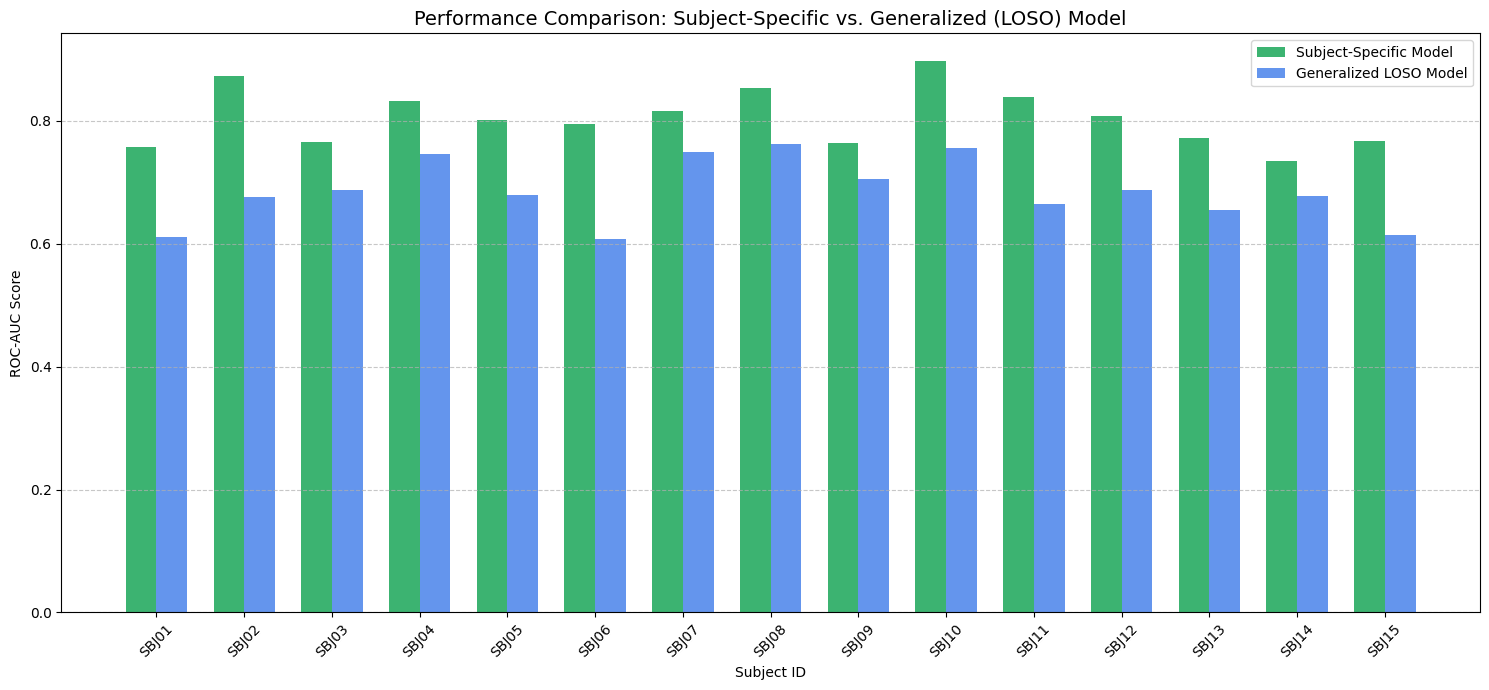


üíæ Results saved to 'loso_vs_subject_specific_results.csv'

üèÅ Total runtime: 60.96 minutes


In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import warnings
import time

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# =============================================================================
# 1. Data Loading & Preprocessing
# =============================================================================

def load_session_data(base_data_path, subject_id, session_id):
    #"""Loads EEG data and labels for a specific subject and session."""
    try:
        data_path = os.path.join(base_data_path, f'SBJ{subject_id:02d}', f'S{session_id:02d}', 'Train')
        mat_file = os.path.join(data_path, 'trainData.mat')
        targets_file = os.path.join(data_path, 'trainTargets.txt')

        mat_contents = sio.loadmat(mat_file)
        eeg_data = mat_contents['trainData']   # shape: (channels, samples, events)
        labels = np.loadtxt(targets_file, dtype=int)
        return eeg_data, labels
    except FileNotFoundError:
        return None, None


def preprocess_eeg(eeg_data, sampling_rate=250):
    #"""Applies band-pass, notch filtering, and baseline correction."""
    low_cut, high_cut = 0.5, 30
    b_band, a_band = butter(4, [low_cut, high_cut], btype='band', fs=sampling_rate)
    eeg_filtered = filtfilt(b_band, a_band, eeg_data, axis=1)

    # 50 Hz notch filter
    notch_freq, q_factor = 50.0, 30.0
    b_notch, a_notch = iirnotch(notch_freq, q_factor, sampling_rate)
    eeg_filtered = filtfilt(b_notch, a_notch, eeg_filtered, axis=1)

    # Baseline correction (first 200 ms)
    baseline_samples = int(0.2 * sampling_rate)
    baseline_mean = np.mean(eeg_filtered[:, :baseline_samples, :], axis=1, keepdims=True)
    eeg_preprocessed = eeg_filtered - baseline_mean
    return eeg_preprocessed


def extract_features(eeg_data, sampling_rate=250):
    #"""Extracts features from a specific time window and flattens them."""
    start_sample = int((200 + 100) * (sampling_rate / 1000))  # 100‚Äì700 ms post-stimulus
    end_sample = int((200 + 700) * (sampling_rate / 1000))

    eeg_windowed = eeg_data[:, start_sample:end_sample, :]
    num_events = eeg_windowed.shape[2]
    num_features = eeg_windowed.shape[0] * eeg_windowed.shape[1]

    features = eeg_windowed.transpose(2, 0, 1).reshape(num_events, num_features)
    return features


# =============================================================================
# 2. LOSO Cross-Validation (Leave-One-Subject-Out)
# =============================================================================

base_data_path = '../data/'
all_subjects = range(1, 16)
sessions_to_process = range(1, 8)

loso_results = []
all_subject_data = {}

print("üì¶ Loading and preprocessing all subject data...")
start_global = time.time()

for subject_id in all_subjects:
    subject_features_list = []
    subject_labels_list = []
    for session_id in sessions_to_process:
        eeg_data, labels = load_session_data(base_data_path, subject_id, session_id)
        if eeg_data is not None:
            eeg_preprocessed = preprocess_eeg(eeg_data)
            features = extract_features(eeg_preprocessed)
            subject_features_list.append(features)
            subject_labels_list.append(labels)

    if subject_features_list:
        all_subject_data[subject_id] = {
            'features': np.vstack(subject_features_list),
            'labels': np.concatenate(subject_labels_list)
        }
        print(f"‚úÖ Loaded Subject {subject_id:02d}: {len(subject_labels_list)} sessions")
    else:
        print(f"‚ö†Ô∏è Skipping Subject {subject_id:02d}: No valid sessions found.")

print("\nüöÄ Starting LOSO Training and Evaluation...\n")
for test_subject_id in all_subjects:
    print(f"--- Testing on Subject {test_subject_id:02d} ---")
    start_time = time.time()

    # Training data = all subjects except the test subject
    train_features_list = [data['features'] for sid, data in all_subject_data.items() if sid != test_subject_id]
    train_labels_list = [data['labels'] for sid, data in all_subject_data.items() if sid != test_subject_id]

    X_train = np.vstack(train_features_list)
    y_train = np.concatenate(train_labels_list)

    # Test data = the held-out subject
    X_test = all_subject_data[test_subject_id]['features']
    y_test = all_subject_data[test_subject_id]['labels']

    print(f"Training on {X_train.shape[0]} events from {len(all_subjects)-1} subjects.")
    print(f"Testing on {X_test.shape[0]} events from subject {test_subject_id:02d}.")

    # --- PCA for feature reduction ---
    print("üîç Running PCA dimensionality reduction...")
    pca = PCA(n_components=150, random_state=42)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    # --- Train model ---
    model = LogisticRegression(
        solver='saga',
        penalty='l2',
        class_weight='balanced',
        random_state=42,
        C=0.1,
        max_iter=1000,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    # --- Evaluate ---
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    loso_results.append({
        'Test_Subject': f'SBJ{test_subject_id:02d}',
        'AUC': auc
    })

    duration = time.time() - start_time
    print(f"‚úÖ Done. Subject {test_subject_id:02d} AUC = {auc:.3f} | ‚è±Ô∏è {duration:.1f}s\n")

# =============================================================================
# 3. Summary Results and Visualization
# =============================================================================

loso_results_df = pd.DataFrame(loso_results)
loso_results_df = loso_results_df.rename(columns={'AUC': 'Generalized_AUC', 'Test_Subject': 'Subject'})

# --- Load subject-specific AUC results from previous experiment ---
# Replace this with your actual subject-specific results DataFrame
subject_results_df = pd.DataFrame(subject_results)

# --- Merge and Compare ---
comparison_df = pd.merge(subject_results_df, loso_results_df, on='Subject')

print("\n--- Generalized Model (LOSO) Performance Summary ---")
print(comparison_df.set_index('Subject'))

# --- Visualization: Subject-Specific vs Generalized ---
plt.figure(figsize=(15, 7))
width = 0.35
x = np.arange(len(comparison_df))

plt.bar(x - width/2, comparison_df['AUC'], width, label='Subject-Specific Model', color='mediumseagreen')
plt.bar(x + width/2, comparison_df['Generalized_AUC'], width, label='Generalized LOSO Model', color='cornflowerblue')

plt.title('Performance Comparison: Subject-Specific vs. Generalized (LOSO) Model', fontsize=14)
plt.ylabel('ROC-AUC Score')
plt.xlabel('Subject ID')
plt.xticks(x, comparison_df['Subject'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Save results ---
comparison_df.to_csv('loso_vs_subject_specific_results.csv', index=False)
print("\nüíæ Results saved to 'loso_vs_subject_specific_results.csv'")

end_global = time.time()
print(f"\nüèÅ Total runtime: {(end_global - start_global)/60:.2f} minutes")
